In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-jan-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-jan-2022/train.csv
/kaggle/input/tabular-playground-series-jan-2022/test.csv


In [2]:
import gc
import random

from IPython import display as ipd
from tqdm import tqdm
import lightgbm as lgb

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, RobustScaler, LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold,GroupKFold

from sklearn.metrics import mean_absolute_error, mean_squared_error, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

### Utils

In [3]:
def seeding(SEED, use_tf=False):
    np.random.seed(SEED)
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    os.environ['TF_CUDNN_DETERMINISTIC'] = str(SEED)
    if use_tf:
        tf.random.set_seed(SEED)
    print('seeding done!!!')
    
## https://www.kaggle.com/c/tabular-playground-series-jan-2022/discussion/298201
def SMAPE(y_true, y_pred):
    denominator = (y_true + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.mean(diff)    

### Data Load

In [4]:
RANDOM_SEED = 42
DEBUG = True

## easy EDA option
PROFILE = False

seeding(RANDOM_SEED)

train = pd.read_csv('/kaggle/input/tabular-playground-series-jan-2022/train.csv')
test = pd.read_csv('/kaggle/input/tabular-playground-series-jan-2022/test.csv')
submission = pd.read_csv('/kaggle/input/tabular-playground-series-jan-2022/sample_submission.csv')

seeding done!!!


In [5]:
train.head()

,row_id,date,country,store,product,num_sold
0,0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329
1,1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520
2,2,2015-01-01,Finland,KaggleMart,Kaggle Sticker,146
3,3,2015-01-01,Finland,KaggleRama,Kaggle Mug,572
4,4,2015-01-01,Finland,KaggleRama,Kaggle Hat,911


## Targets distribution display

Text(0.5, 1.0, 'Sweden')

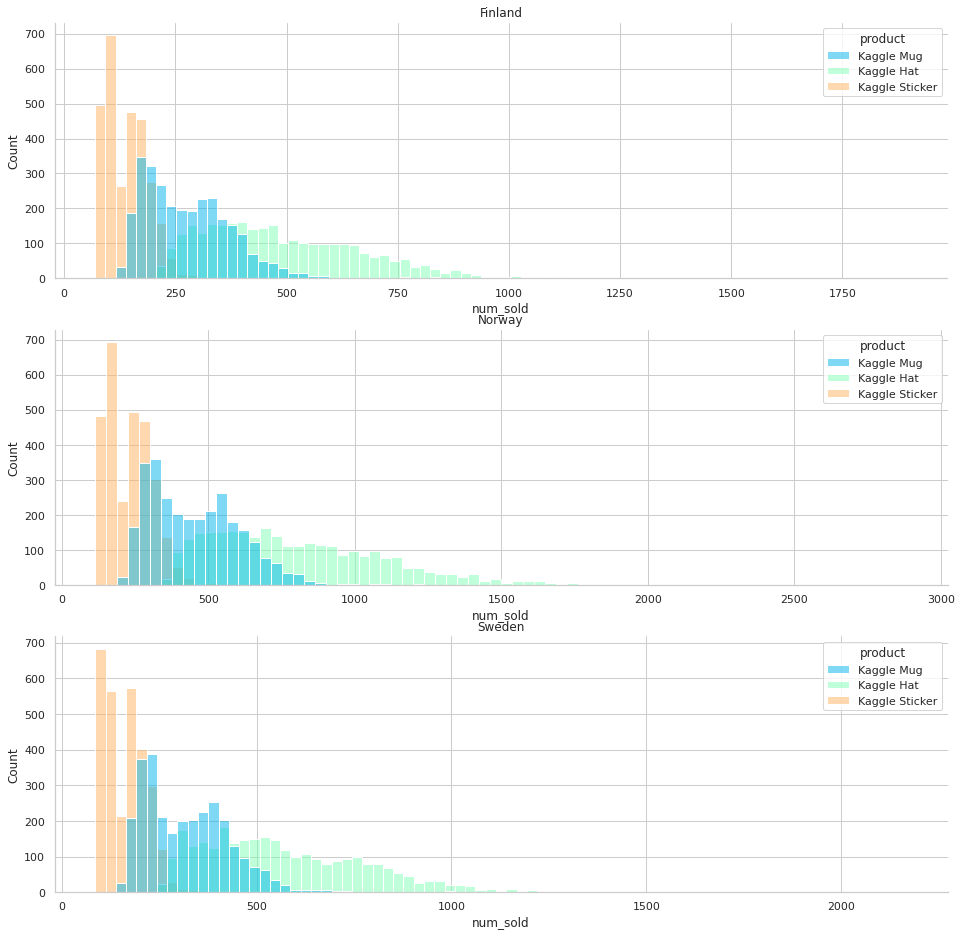

In [6]:
## targets distribution by country

f, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(16, 16))
sns.despine(f)
g1 = sns.histplot( data=train[train['country'] == 'Finland'], x = 'num_sold', hue='product', ax=ax1,  palette="rainbow")
g1.set_title("Finland")
g2 = sns.histplot( data=train[train['country'] == 'Norway'], x = 'num_sold', hue='product', ax=ax2,  palette="rainbow")
g2.set_title("Norway")
g3 = sns.histplot( data=train[train['country'] == 'Sweden'], x = 'num_sold', hue='product', ax=ax3,  palette="rainbow")
g3.set_title("Sweden")

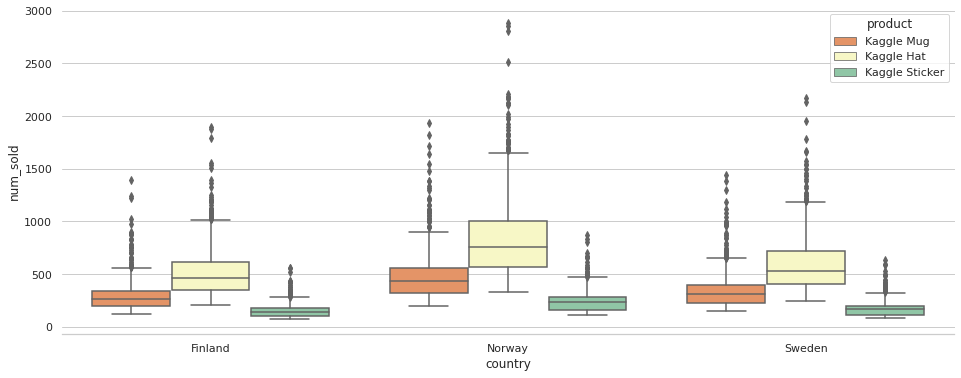

In [7]:
f, ax1 = plt.subplots(1, 1, figsize=(16, 6))

sns.boxplot( data=train, x="country", y="num_sold", hue="product", ax=ax1, palette="Spectral")
sns.despine(left=True)

<AxesSubplot:xlabel='product', ylabel='num_sold'>

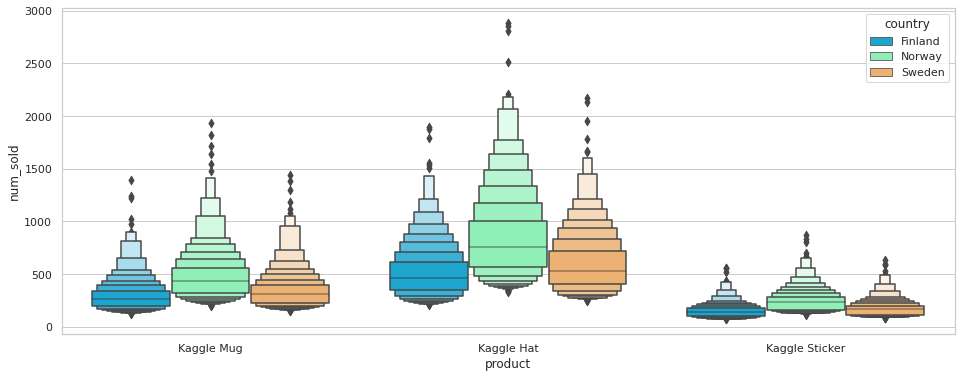

In [8]:
## Another nice way of showing distribution

f, ax1 = plt.subplots(1, 1, figsize=(16, 6))
product_order = ["Kaggle Mug", "Kaggle Hat", "Kaggle Sticker"]
sns.boxenplot(x="product", y="num_sold", palette="rainbow", hue='country', order=product_order, scale="linear", data=train)

### Very simple date-based FE

In [9]:
def process_dates(df):
    df.date = pd.to_datetime(df.date)
    df['month'] = df.date.dt.month
    df['week'] = df.date.dt.week
    df['weekday'] = df.date.dt.weekday
    df['dayofweek'] = df.date.dt.dayofweek
    df['dayofyear'] = df.date.dt.dayofyear
    df['day'] = df.date.dt.day
    return df

train = process_dates(train)
test = process_dates(test)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  after removing the cwd from sys.path.


In [10]:
print(f'Train unique days: {train.day.unique().size}, test: {test.day.unique().size}')
print(f'Train unique weeks: {train.week.unique().size}, test: {test.week.unique().size}')
print(f'Train unique dayofweeks: {train.dayofweek.unique().size}, test: {train.dayofweek.unique().size}')
print(f'Train unique months: {train.month.unique().size}, test: {train.month.unique().size}')
print(f'Train unique dayofyear: {train.dayofyear.unique().size}, test: {train.dayofyear.unique().size}')

Train unique days: 31, test: 31
Train unique weeks: 53, test: 52
Train unique dayofweeks: 7, test: 7
Train unique months: 12, test: 12
Train unique dayofyear: 366, test: 366


In [11]:
target = train.num_sold
train.drop(['row_id','num_sold','date'], axis=1, inplace=True)
test.drop(['row_id', 'date'], axis=1, inplace=True)

### Encode category columns 

In [12]:
country_encoder = LabelEncoder()
train['country_enc'] = country_encoder.fit_transform(train['country'])
test['country_enc'] = country_encoder.transform(test['country'])

store_encoder = LabelEncoder()
train['store_enc'] = store_encoder.fit_transform(train['store'])
test['store_enc'] = store_encoder.transform(test['store'])

product_encoder = LabelEncoder()
train['product_enc'] = product_encoder.fit_transform(train['product'])
test['product_enc'] = product_encoder.transform(test['product'])

train.drop(['country','store','product'], axis=1, inplace=True)
test.drop(['country','store','product'], axis=1, inplace=True)

In [13]:
for col in train.columns:
    train[col] = pd.Categorical(train[col])
for col in test.columns:
    test[col] = pd.Categorical(test[col])

### Model and train

In [14]:
def run_train(X, y, run_params, splits, num_boost_round, verbose_eval, early_stopping_rounds ):
    scores = []
    models = []
    eval_results = {}  # to record eval results for plotting
    folds = StratifiedKFold(n_splits=splits)
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        print(f'Fold {fold_n+1} started')
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        model = lgb.train(
            run_params, valid_names=["train", "valid"], 
            train_set=lgb.Dataset(X_train, y_train ), 
            num_boost_round = num_boost_round,
            valid_sets = [lgb.Dataset(X_valid, y_valid)],
            callbacks=[lgb.log_evaluation(verbose_eval), 
               lgb.early_stopping(early_stopping_rounds, False, True),
               lgb.record_evaluation(eval_result=eval_results)],
        )

        y_predicted = model.predict(X_valid)
        score = SMAPE(y_valid, y_predicted)   
        print(f'SMAPE: {score}')

        models.append(model)
        scores.append(score)
    return scores, models, eval_results


LEARNING_RATE = 0.075
MAX_DEPTH = 20
NUM_LEAVES = 350  
TOTAL_SPLITS = 5
NUM_BOOST_ROUND = 2000
EARLY_STOPPING_ROUNDS = 50
VERBOSE_EVAL = 100
    
run_params = {
    'verbose': -1, 
    'boosting_type': 'gbdt', 
    'objective': 'regression', 
    'metric': ['rmse'],
    'learning_rate': LEARNING_RATE, 
    'num_leaves': NUM_LEAVES, 
    'max_depth': MAX_DEPTH, 
    'min_data_in_leaf': 200,
    'max_bin': 250,
    'lambda_l1': 100,
    'lambda_l2': 95,
    'feature_fraction': 0.97,
    'bagging_fraction': 0.99,
    'bagging_freq': 2,
    'min_child_samples': 77,
}

FEATURES = [col for col in train.columns if col.endswith('enc')]
scores, models, eval_results = run_train(train, target, run_params, TOTAL_SPLITS, NUM_BOOST_ROUND, 
                                          VERBOSE_EVAL, EARLY_STOPPING_ROUNDS)
print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Fold 1 started
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=77 will be ignored. Current value: min_data_in_leaf=200
Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 60.4116
[200]	train's rmse: 53.4676
[300]	train's rmse: 50.3852
[400]	train's rmse: 48.6708
[500]	train's rmse: 47.7127
[600]	train's rmse: 47.1002
[700]	train's rmse: 46.7062
[800]	train's rmse: 46.3973
[900]	train's rmse: 46.1683
[1000]	train's rmse: 45.9416
[1100]	train's rmse: 45.7822
[1200]	train's rmse: 45.6166
[1300]	train's rmse: 45.4995
[1400]	train's rmse: 45.403
[1500]	train's rmse: 45.3361
[1600]	train's rmse: 45.2882
[1700]	train's rmse: 45.2362
[1800]	train's rmse: 45.2022
[1900]	train's rmse: 45.1726
[2000]	train's rmse: 45.1392
Did not meet early stopping. Best iteration is:
[1996]	train's rmse: 45.139
SMAPE: 8.0769260657981
Fold 2 started
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=77 will be ignored. Current value: min_data_in_l

### Plot metrics

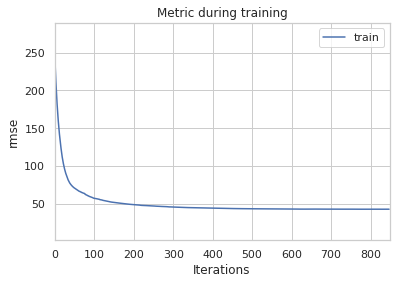

In [15]:
ax = lgb.plot_metric(eval_results, metric='rmse')
plt.show()

In [16]:
y_pred = np.zeros(len(test))
for model in models:
    y_pred += model.predict(test).reshape(-1)
    
y_pred = y_pred / len(models)

In [17]:
submission['num_sold'] = np.round(y_pred).astype(int)
submission.to_csv('submission.csv', index=False, float_format='%.6f')
submission.head(20)

,row_id,num_sold
0,26298,376
1,26299,552
2,26300,114
3,26301,667
4,26302,989
5,26303,270
6,26304,603
7,26305,918
8,26306,263
9,26307,975
